In [ ]:
from google.colab import files
uploaded = files.upload()


Saving realistic_customer_risk_dataset.csv to realistic_customer_risk_dataset.csv


In [ ]:
import pandas as pd

df = pd.read_csv("realistic_customer_risk_dataset.csv")
df.head()


,customer_id,age,gender,income,employment_type,credit_score,loan_amount,loan_tenure_months,num_previous_loans,default_history,monthly_spend,transaction_count,late_payments,region,account_age_months,target
0,1,56,Male,139677,Student,385,640254,34,3,0,56165,67,6,West,145,1
1,2,69,Female,191422,Salaried,343,142854,43,1,0,65690,59,0,North,30,0
2,3,46,Female,158273,Unemployed,436,628640,115,5,0,38948,155,9,West,26,0
3,4,32,Male,44426,Student,720,424149,102,8,0,29007,38,11,West,125,0
4,5,60,Male,32778,Student,373,668667,23,8,0,102819,109,4,South,19,1


In [ ]:
print("DATA SHAPE:", df.shape)
display(df.head())
print("\nInfo:")
print(df.info())
print("\nTarget counts:")
print(df["target"].value_counts(), "\nNormalized:")
print(df["target"].value_counts(normalize=True))

DATA SHAPE: (1200, 16)


,customer_id,age,gender,income,employment_type,credit_score,loan_amount,loan_tenure_months,num_previous_loans,default_history,monthly_spend,transaction_count,late_payments,region,account_age_months,target
0,1,56,Male,139677,Student,385,640254,34,3,0,56165,67,6,West,145,1
1,2,69,Female,191422,Salaried,343,142854,43,1,0,65690,59,0,North,30,0
2,3,46,Female,158273,Unemployed,436,628640,115,5,0,38948,155,9,West,26,0
3,4,32,Male,44426,Student,720,424149,102,8,0,29007,38,11,West,125,0
4,5,60,Male,32778,Student,373,668667,23,8,0,102819,109,4,South,19,1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         1200 non-null   int64 
 1   age                 1200 non-null   int64 
 2   gender              1200 non-null   object
 3   income              1200 non-null   int64 
 4   employment_type     1200 non-null   object
 5   credit_score        1200 non-null   int64 
 6   loan_amount         1200 non-null   int64 
 7   loan_tenure_months  1200 non-null   int64 
 8   num_previous_loans  1200 non-null   int64 
 9   default_history     1200 non-null   int64 
 10  monthly_spend       1200 non-null   int64 
 11  transaction_count   1200 non-null   int64 
 12  late_payments       1200 non-null   int64 
 13  region              1200 non-null   object
 14  account_age_months  1200 non-null   int64 
 15  target              1200 non-null   int64 
dtypes: int64(13), obj

In [ ]:
#  Preprocess + split
# -------------------------
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# prepare features
X = df.drop(columns=["target","customer_id"])
y = df["target"].astype(int)

numeric_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
print("\nNumeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

numeric_transformer = SimpleImputer(strategy="median")
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTrain size:", X_train.shape, "Test size:", X_test.shape)



Numeric cols: ['age', 'income', 'credit_score', 'loan_amount', 'loan_tenure_months', 'num_previous_loans', 'default_history', 'monthly_spend', 'transaction_count', 'late_payments', 'account_age_months']
Categorical cols: ['gender', 'employment_type', 'region']

Train size: (960, 14) Test size: (240, 14)


In [ ]:
# Build pipeline & train XGBoost
# -------------------------
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib

model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

clf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])

print("\nTraining model (this may take a minute)...")
clf.fit(X_train, y_train)

# evaluation
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print("=== ROC AUC ===")
print(roc_auc_score(y_test, y_proba))

# save pipeline
joblib.dump(clf, "/content/final_pipeline.pkl")
print("Saved pipeline to /content/final_pipeline.pkl")


Training model (this may take a minute)...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:37:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       169
           1       0.70      0.72      0.71        71

    accuracy                           0.82       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.83      0.82      0.83       240

=== Confusion Matrix ===
[[147  22]
 [ 20  51]]
=== ROC AUC ===
0.9051587632302691
Saved pipeline to /content/final_pipeline.pkl


In [ ]:
# -------------------------
#  Feature names & SHAP explainer
# -------------------------
pre = clf.named_steps["preprocessor"]
num_cols_after = pre.transformers_[0][2]
cat_pipe = pre.transformers_[1][1]
ohe = cat_pipe.named_steps["onehot"]
cat_cols_after = pre.transformers_[1][2]
ohe_feature_names = list(ohe.get_feature_names_out(cat_cols_after))
feature_names = list(num_cols_after) + ohe_feature_names
print("\nTotal transformed features:", len(feature_names))

X_train_trans = pre.transform(X_train)

import shap
explainer = shap.TreeExplainer(clf.named_steps["model"])
shap_values = explainer.shap_values(X_train_trans)
import numpy as np
print("SHAP values shape:", np.shape(shap_values))


Total transformed features: 21
SHAP values shape: (960, 21)


In [ ]:
# -------------------------
# Save global SHAP plots
# -------------------------
import matplotlib.pyplot as plt
import os
os.makedirs("/content/outputs/edge_cases", exist_ok=True)

# Summary / beeswarm
shap.summary_plot(shap_values, X_train_trans, feature_names=feature_names, show=False)
plt.title("SHAP Summary (Beeswarm)")
plt.tight_layout()
plt.savefig("/content/outputs/shap_summary.png", dpi=200)
plt.clf()

# Bar plot (mean abs)
shap.summary_plot(shap_values, X_train_trans, feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar)")
plt.tight_layout()
plt.savefig("/content/outputs/shap_bar.png", dpi=200)
plt.clf()

# Dependence plot for top feature
mean_abs = np.abs(shap_values).mean(axis=0)
top_idx = np.argmax(mean_abs)
top_feature = feature_names[top_idx]
print("\nTop feature by mean |SHAP|:", top_feature)
shap.dependence_plot(top_feature, shap_values, X_train_trans, feature_names=feature_names, show=False)
plt.title(f"Dependence: {top_feature}")
plt.tight_layout()
plt.savefig(f"/content/outputs/dependence_{top_feature}.png", dpi=200)
plt.clf()

print("Saved global SHAP plots to /content/outputs/")


Top feature by mean |SHAP|: loan_amount
Saved global SHAP plots to /content/outputs/


<Figure size 800x950 with 0 Axes>

<Figure size 750x500 with 0 Axes>

In [ ]:
# -------------------------
# Edge-case selection and local force plots (PNG + HTML)
# -------------------------
import numpy as np
y_test_arr = np.array(y_test)
y_pred_arr = np.array(y_pred)

false_neg_idx = np.where((y_test_arr == 1) & (y_pred_arr == 0))[0]
false_pos_idx = np.where((y_test_arr == 0) & (y_pred_arr == 1))[0]

print("\nFalse Negatives:", len(false_neg_idx))
print("False Positives:", len(false_pos_idx))

# select up to 3 FN + 2 FP
selected = list(false_neg_idx[:3]) + list(false_pos_idx[:2])
print("Selected X_test indices (relative to X_test):", selected)

# generate plots
for i, rel_idx in enumerate(selected):
    instance = X_test.iloc[rel_idx:rel_idx+1]
    inst_trans = pre.transform(instance)

    # static PNG (matplotlib)
    shap.force_plot(explainer.expected_value, explainer.shap_values(inst_trans), inst_trans,
                    feature_names=feature_names, matplotlib=True, show=False)
    png_path = f"/content/outputs/edge_cases/force_case_{i+1}.png"
    plt.savefig(png_path, dpi=200, bbox_inches="tight")
    plt.clf()

    # interactive HTML
    html = shap.force_plot(explainer.expected_value, explainer.shap_values(inst_trans), inst_trans,
                           feature_names=feature_names, matplotlib=False)
    html_path = f"/content/outputs/edge_cases/force_case_{i+1}.html"
    try:
        shap.save_html(html_path, html)
    except Exception as e:
        # fallback: write raw HTML
        with open(html_path, "w") as fh:
            fh.write(str(html))
    print("Saved:", png_path, "and", html_path)

print("Saved local force plots (PNG + HTML) to /content/outputs/edge_cases/")


False Negatives: 20
False Positives: 22
Selected X_test indices (relative to X_test): [np.int64(1), np.int64(10), np.int64(33), np.int64(2), np.int64(14)]
Saved: /content/outputs/edge_cases/force_case_1.png and /content/outputs/edge_cases/force_case_1.html
Saved: /content/outputs/edge_cases/force_case_2.png and /content/outputs/edge_cases/force_case_2.html
Saved: /content/outputs/edge_cases/force_case_3.png and /content/outputs/edge_cases/force_case_3.html
Saved: /content/outputs/edge_cases/force_case_4.png and /content/outputs/edge_cases/force_case_4.html
Saved: /content/outputs/edge_cases/force_case_5.png and /content/outputs/edge_cases/force_case_5.html
Saved local force plots (PNG + HTML) to /content/outputs/edge_cases/



--- Displaying saved PNGs ---


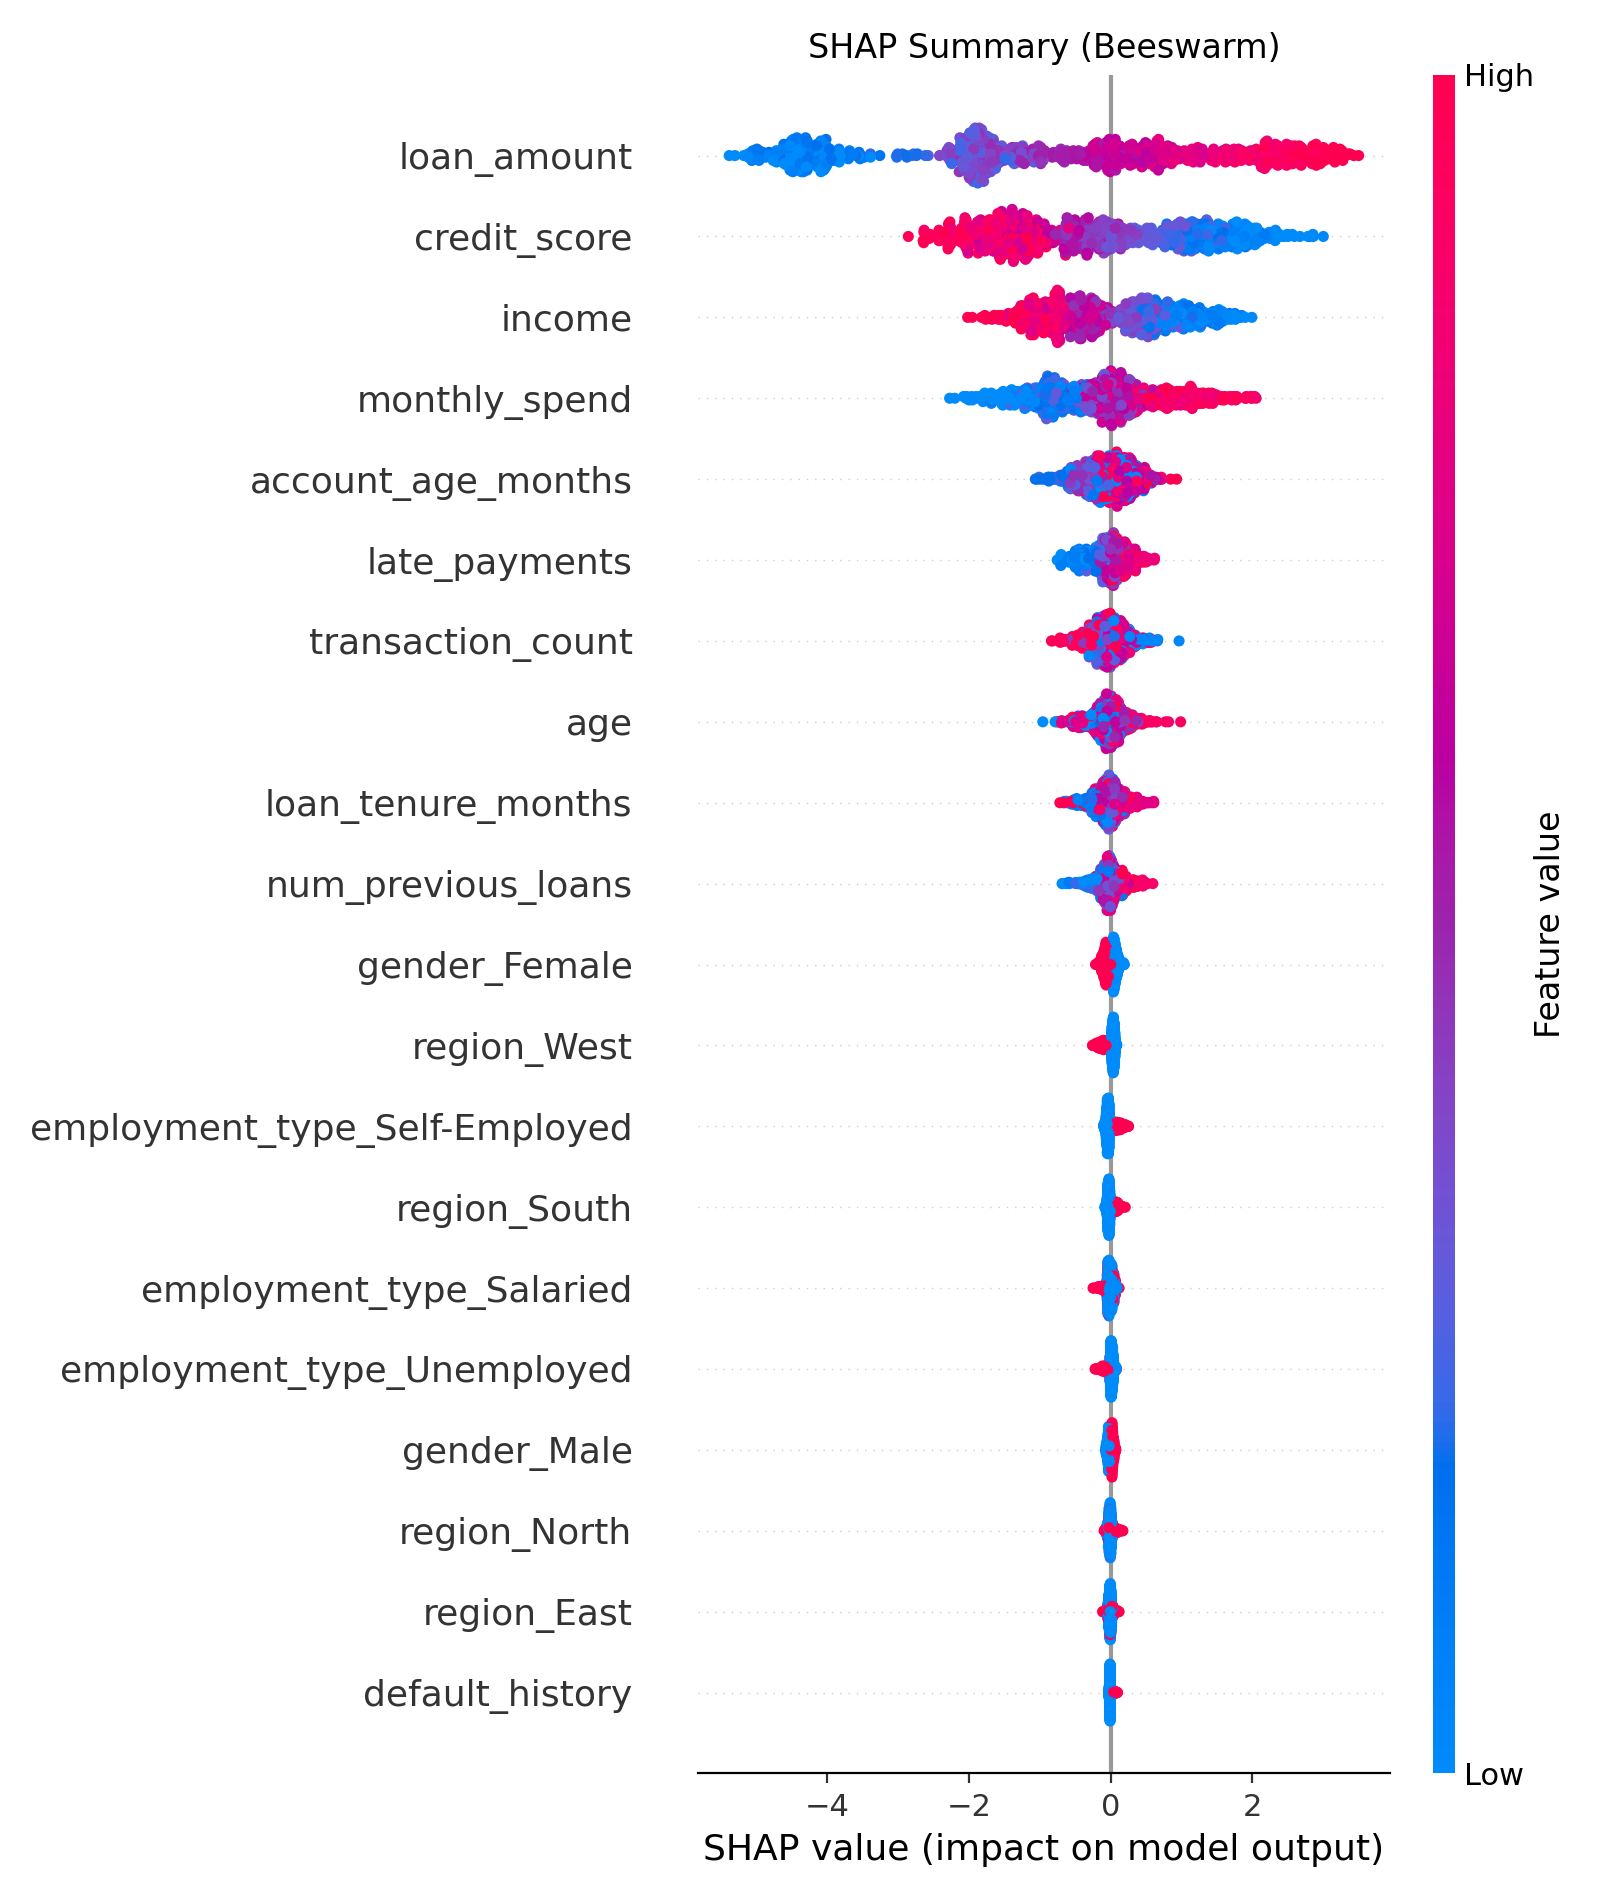

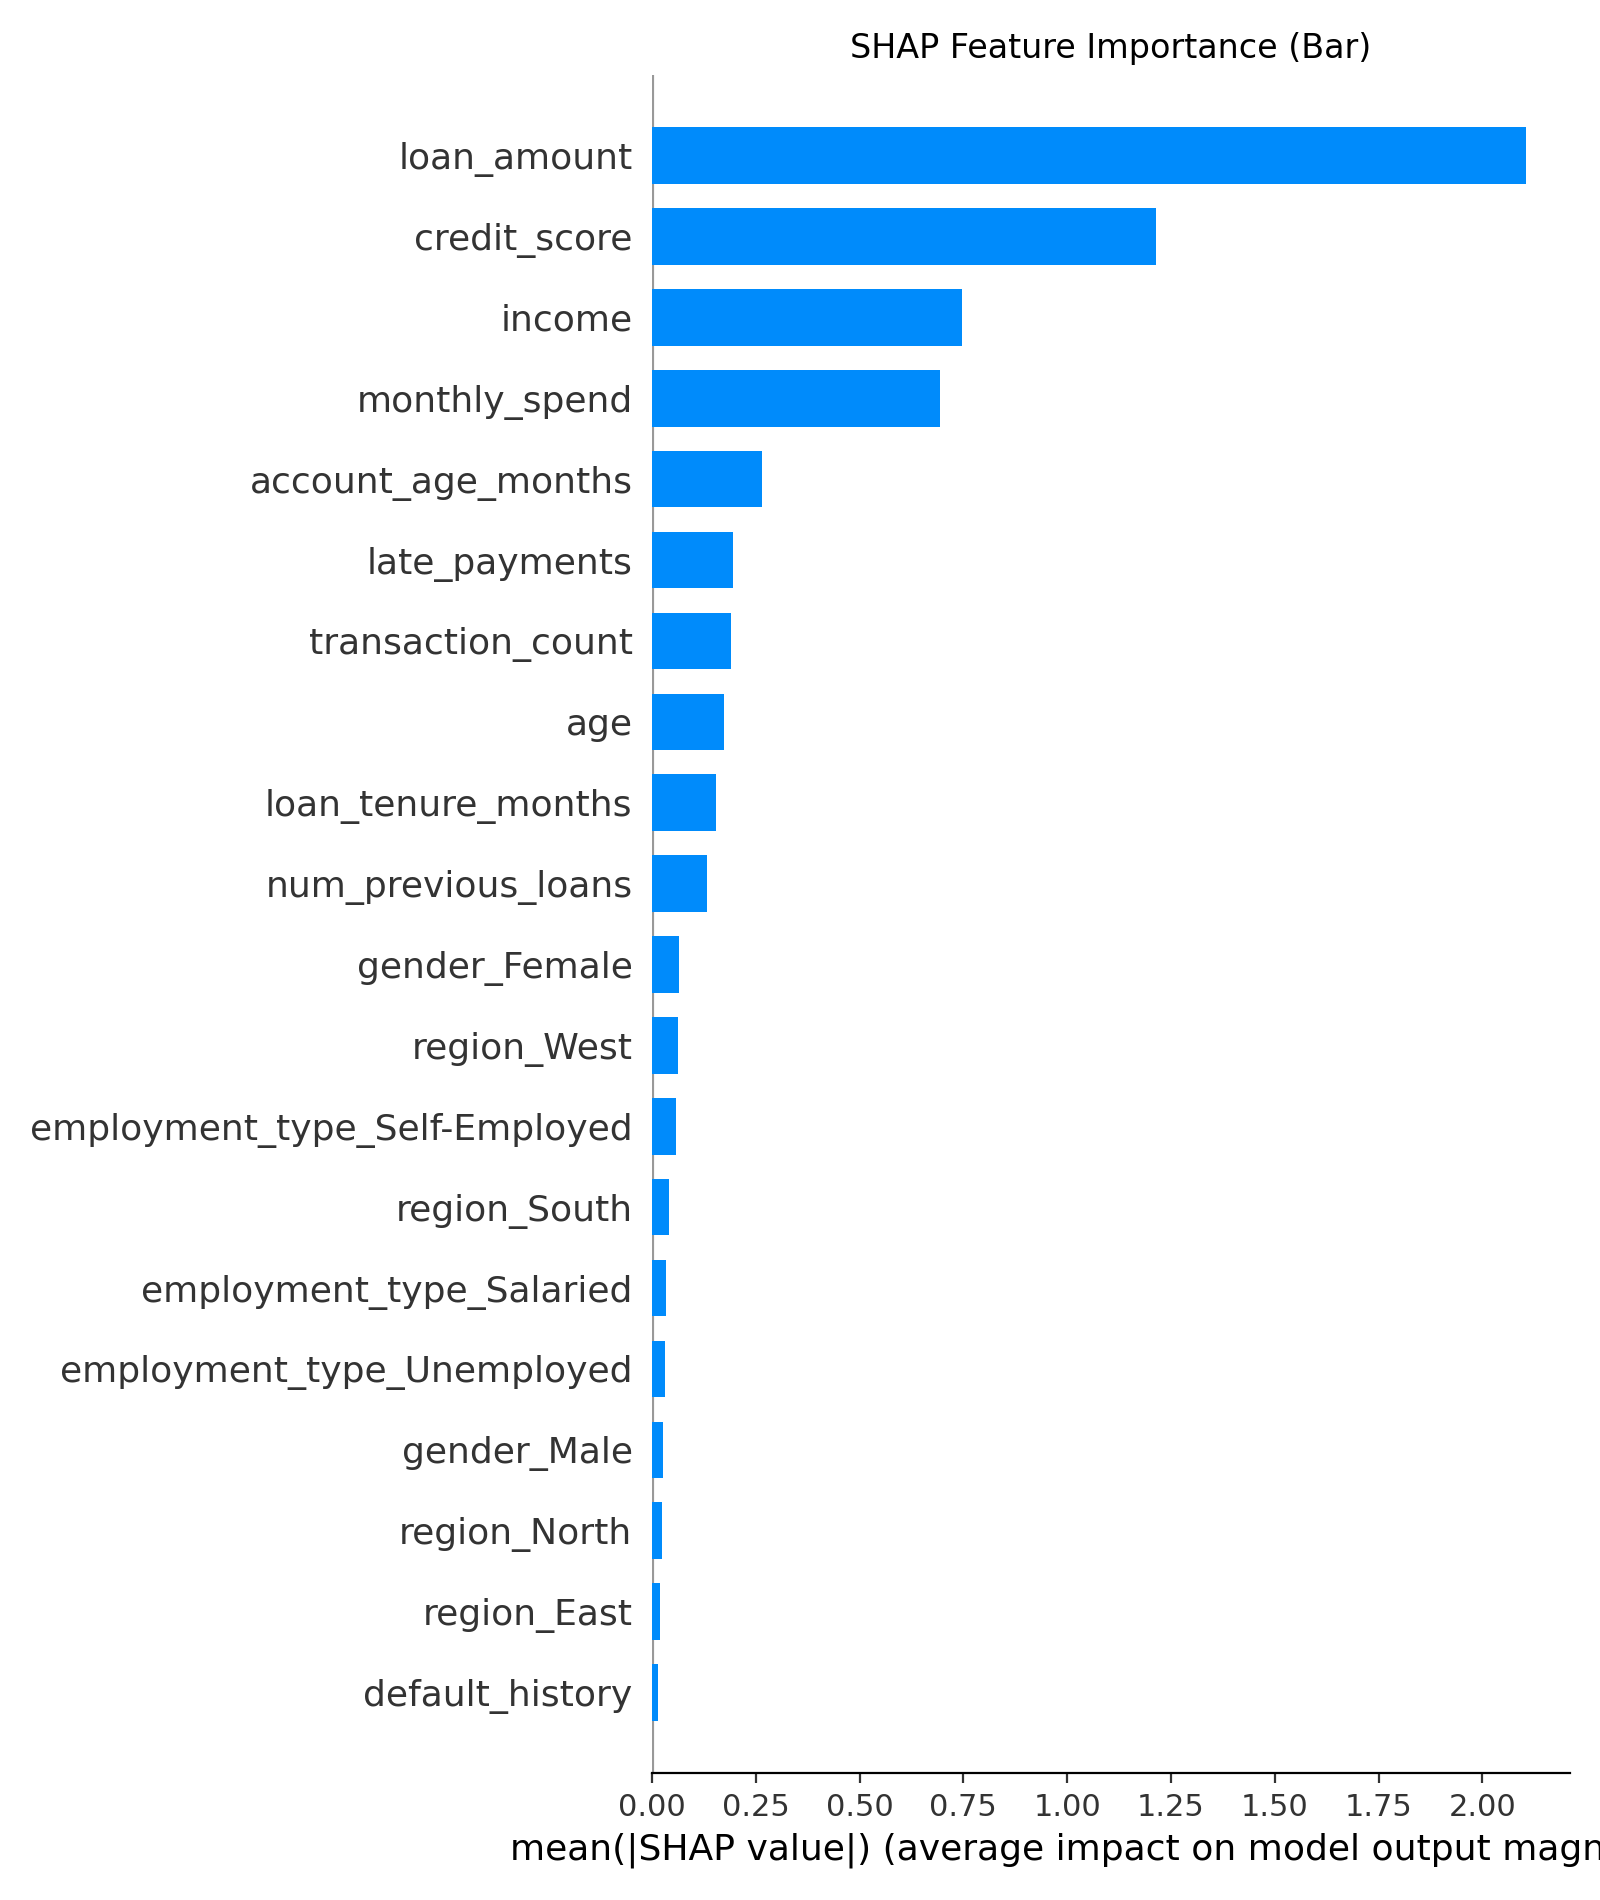

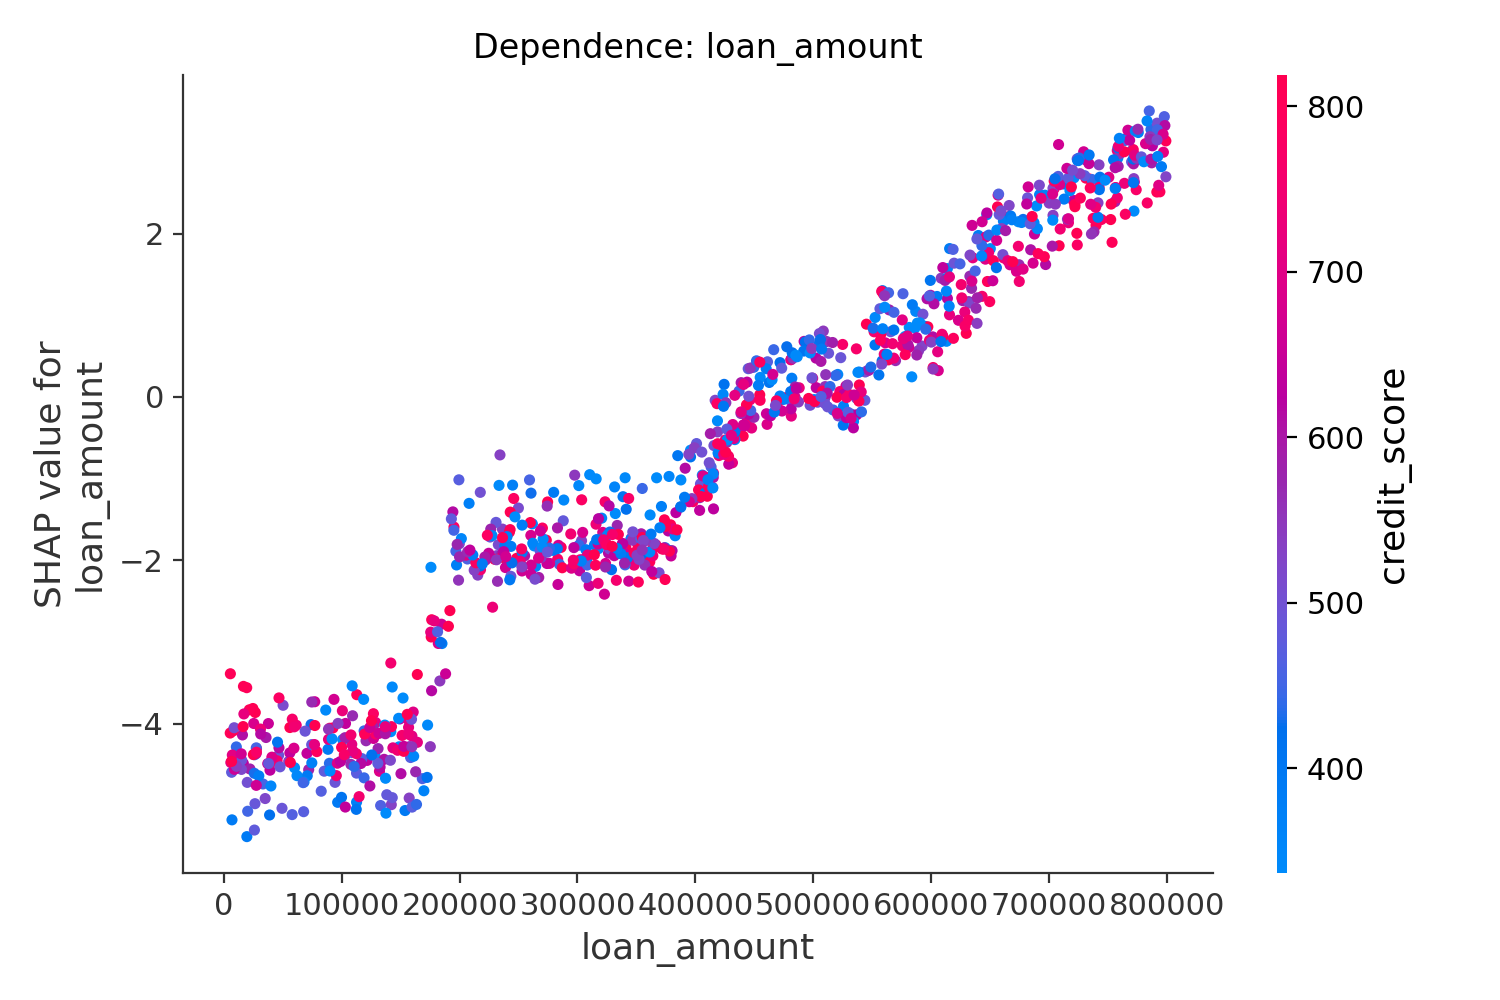


Showing: /content/outputs/edge_cases/force_case_1.png


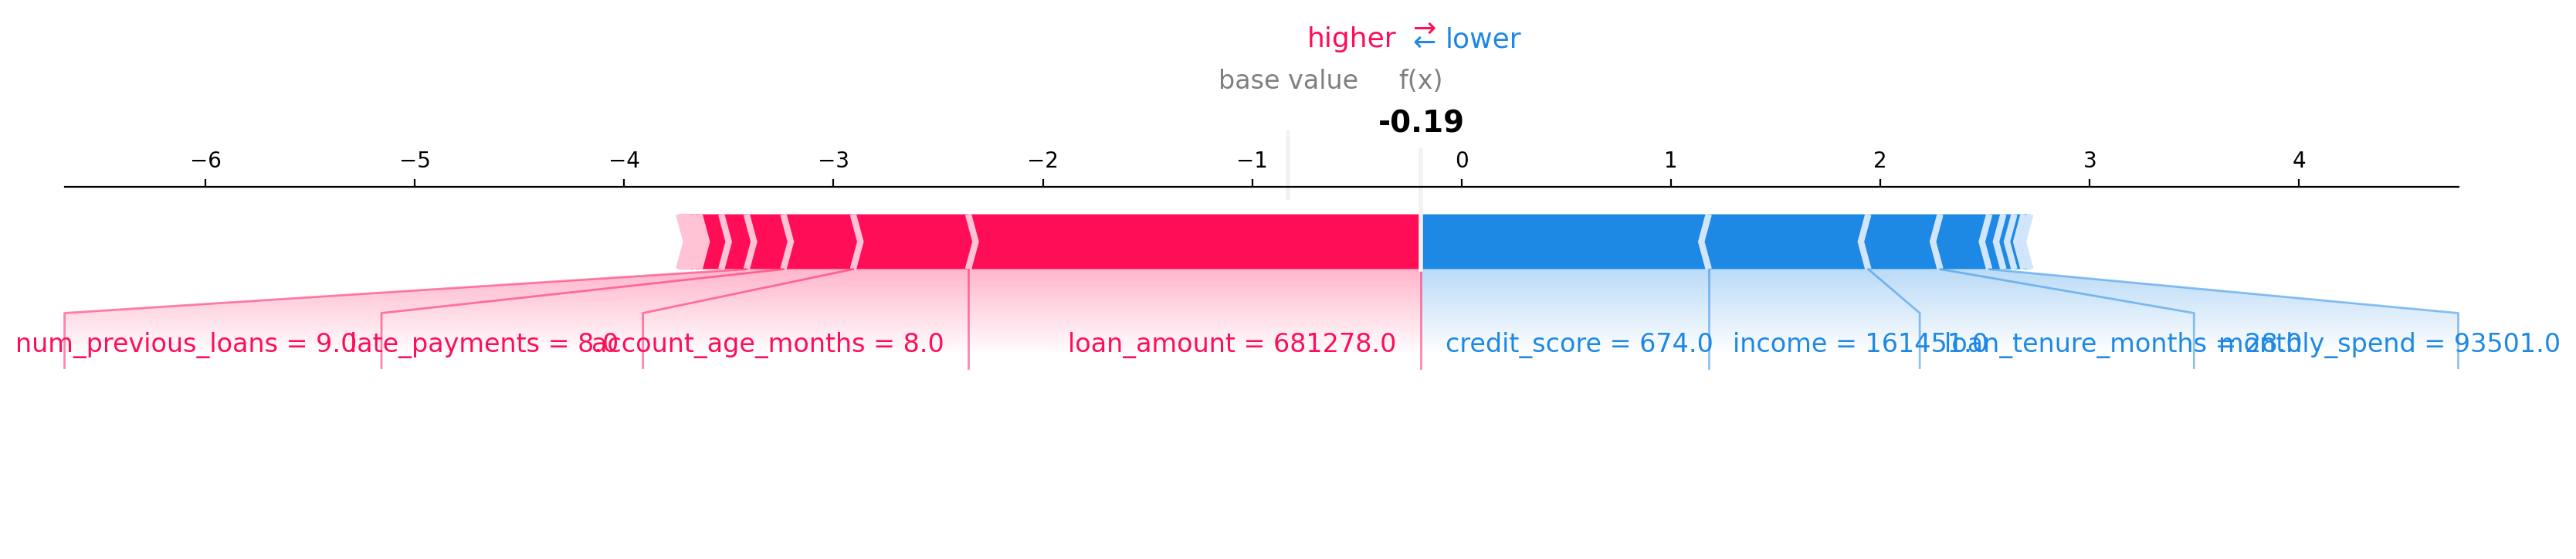


Showing: /content/outputs/edge_cases/force_case_2.png


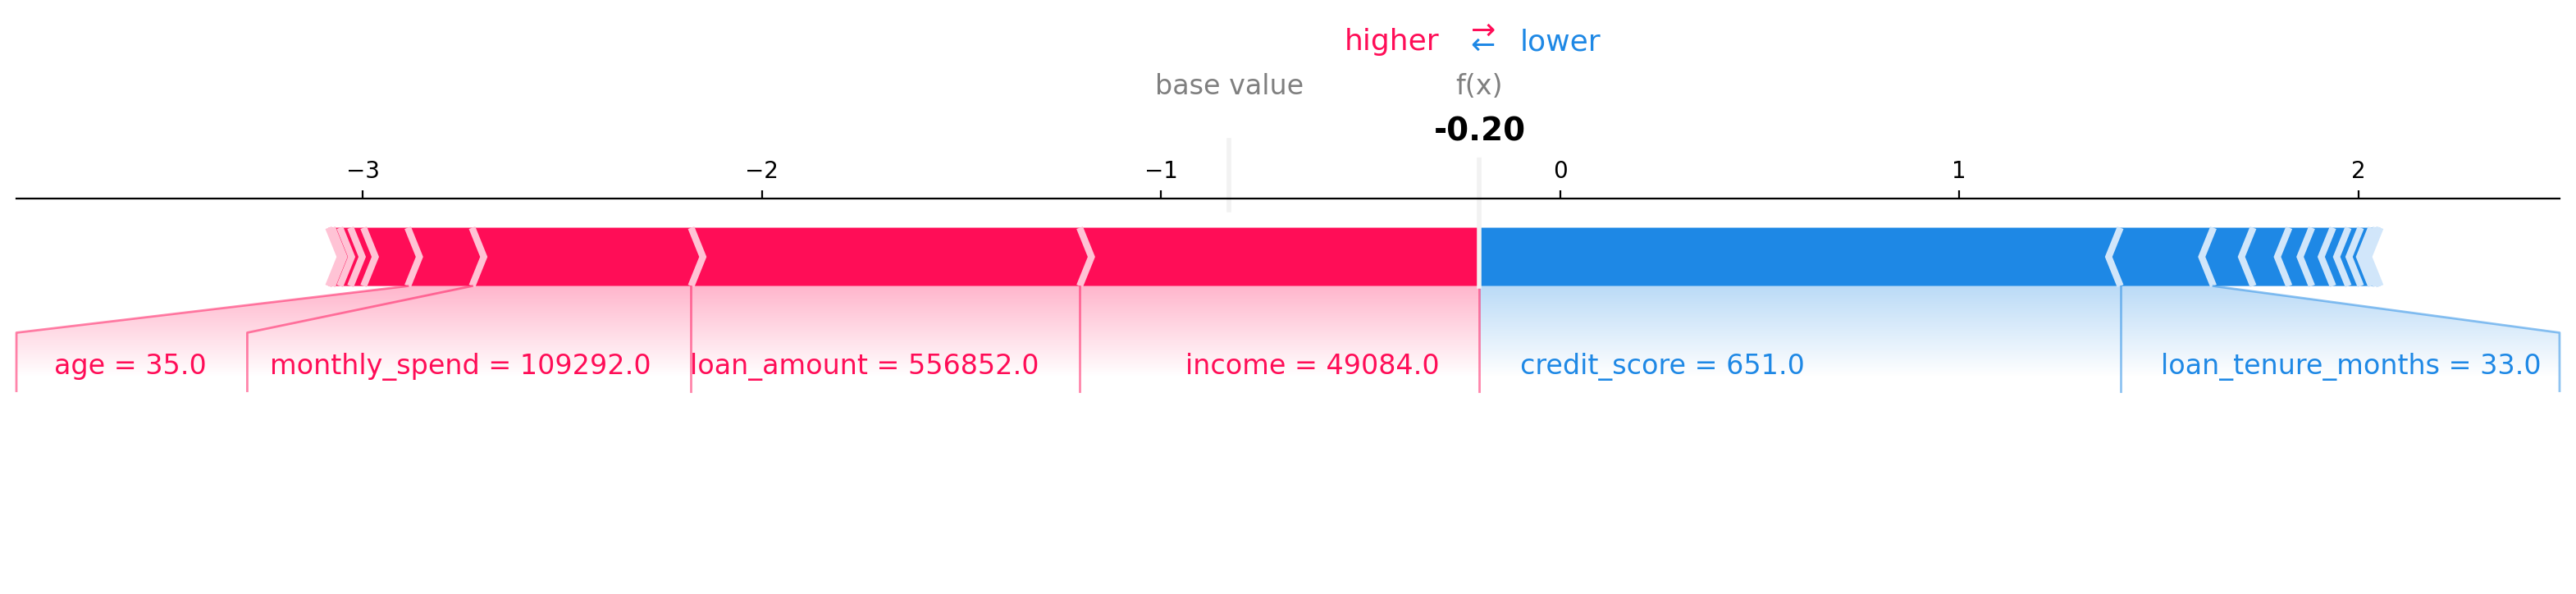


Showing: /content/outputs/edge_cases/force_case_3.png


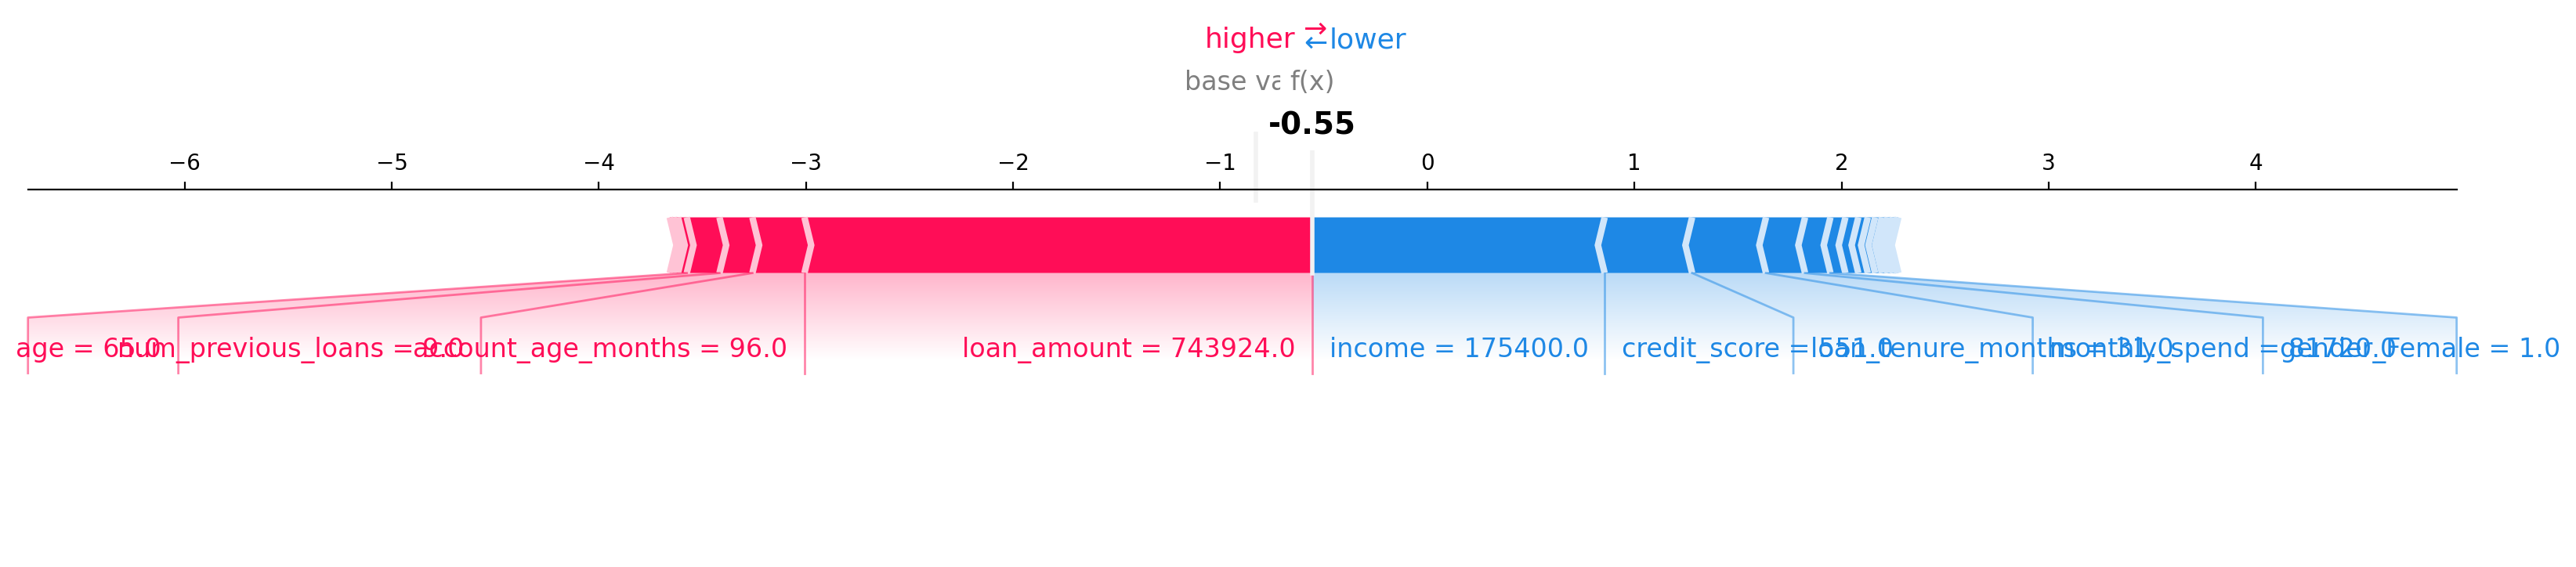


Showing: /content/outputs/edge_cases/force_case_4.png


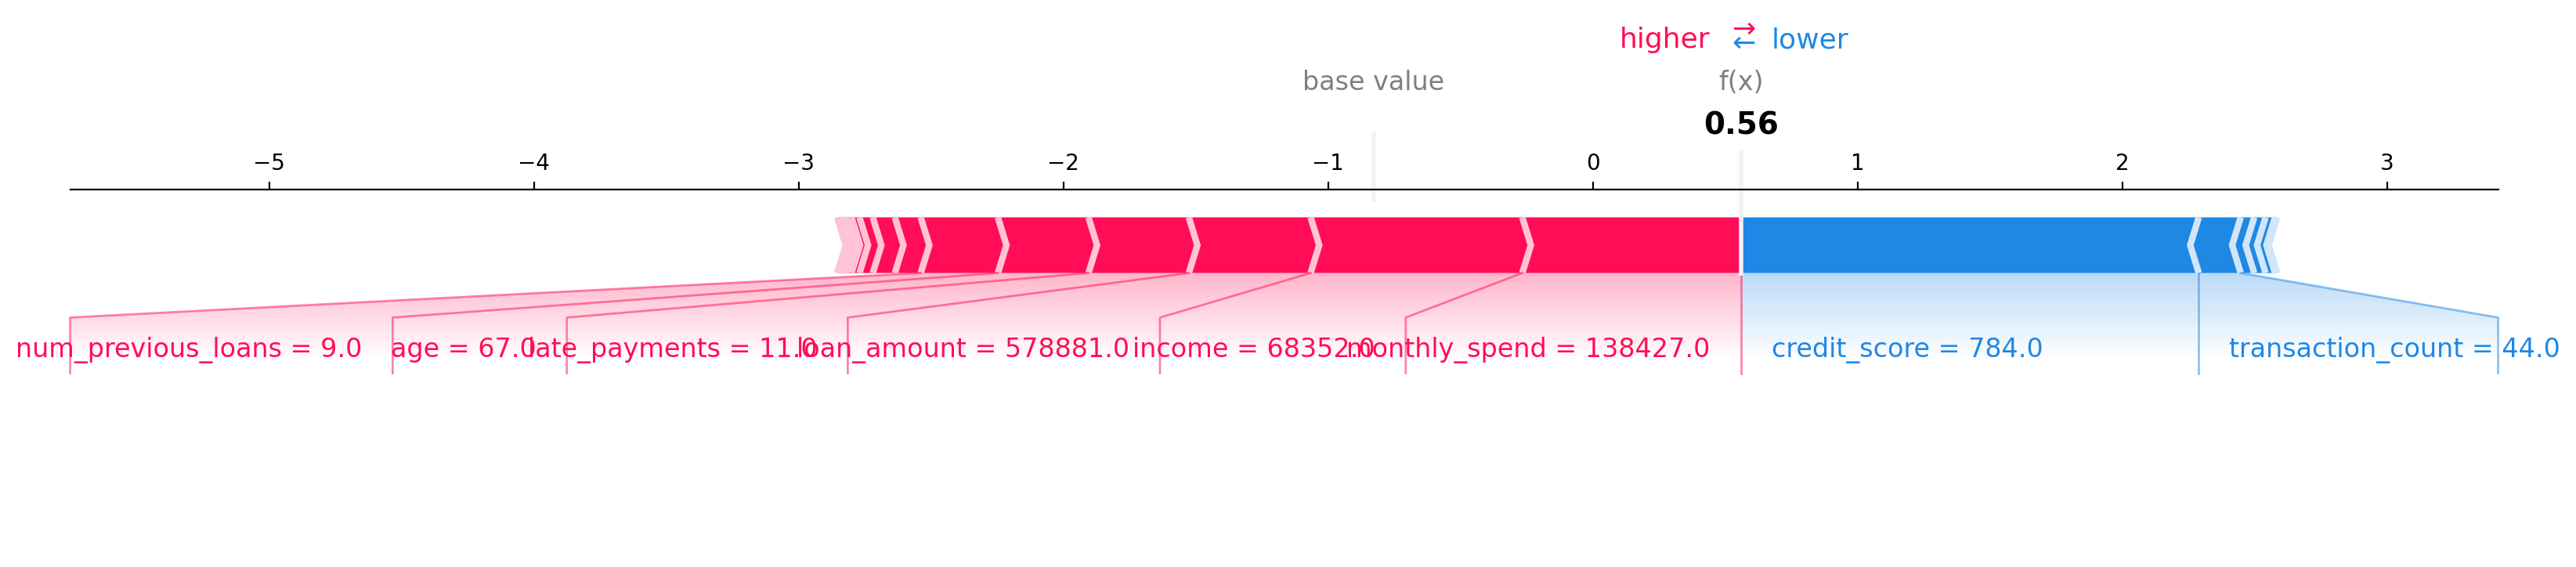


Showing: /content/outputs/edge_cases/force_case_5.png


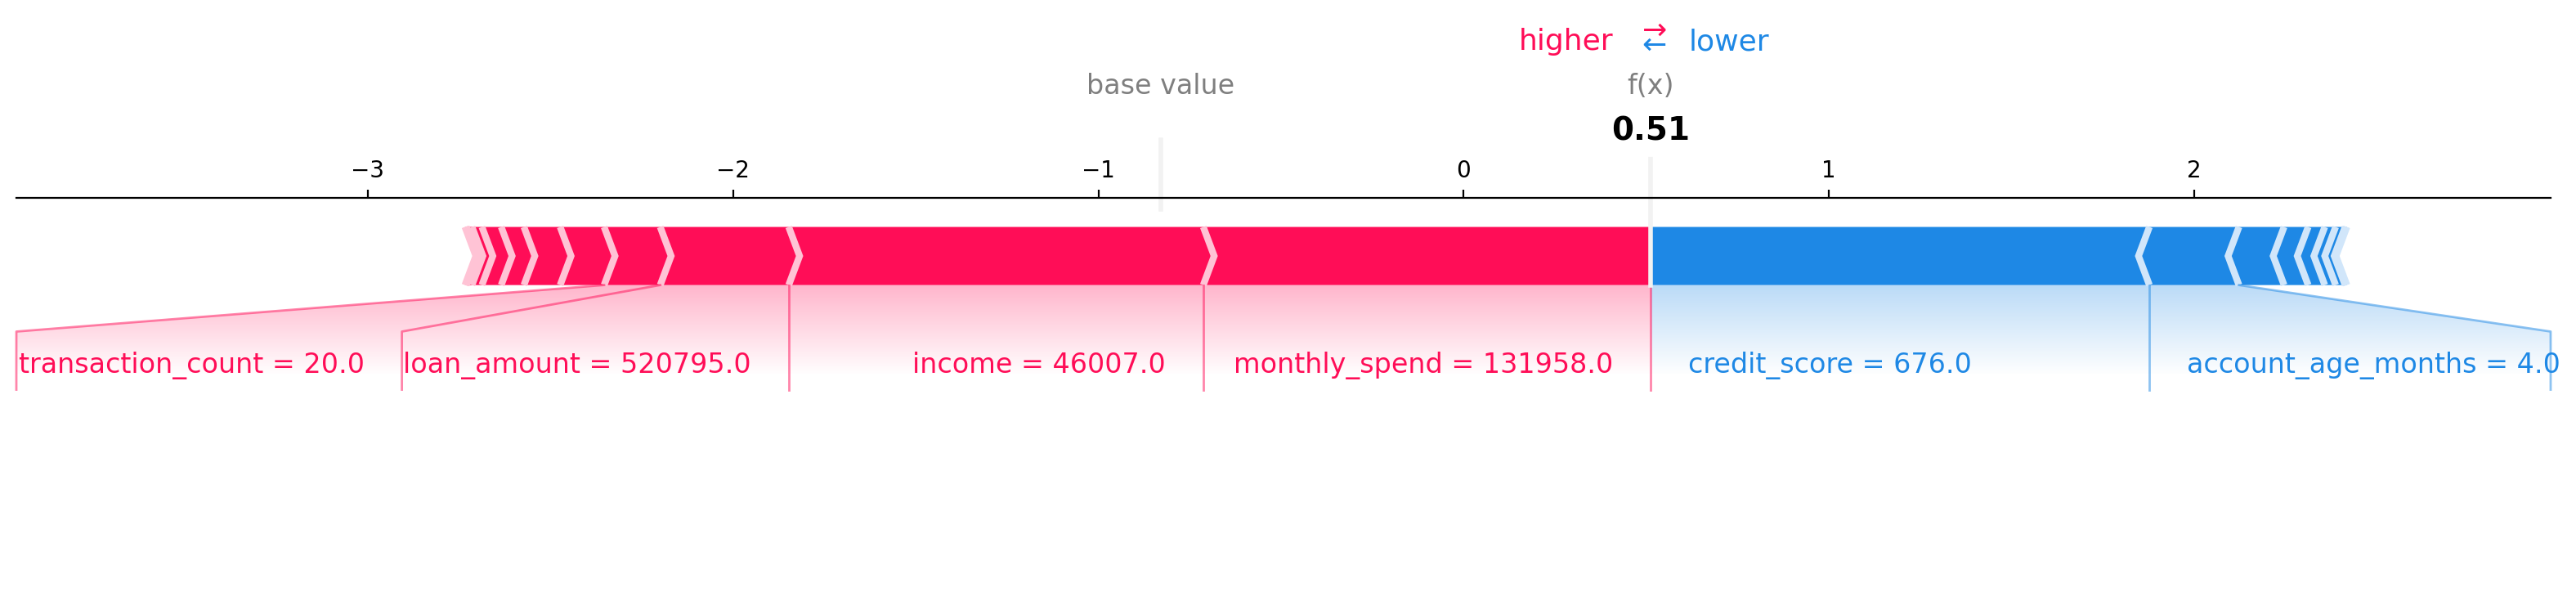

In [ ]:
# -------------------------
#  Display all plots inline (quick visual check)
# -------------------------
from IPython.display import Image, display
print("\n--- Displaying saved PNGs ---")
display(Image("/content/outputs/shap_summary.png"))
display(Image("/content/outputs/shap_bar.png"))
display(Image(f"/content/outputs/dependence_{top_feature}.png"))
for i in range(1, 6):
    p = f"/content/outputs/edge_cases/force_case_{i}.png"
    if os.path.exists(p):
        print("\nShowing:", p)
        display(Image(p))
    else:
        print("\nMissing:", p)

In [ ]:
# -------------------------
#  Save explanations.md with case feature values
# -------------------------
with open("/content/outputs/edge_cases/explanations.md","w") as fh:
    fh.write("# Edge Case Explanations\n\n")
    for i, rel_idx in enumerate(selected):
        row = X_test.iloc[rel_idx:rel_idx+1]
        fh.write(f"## Case {i+1} — X_test index {rel_idx}\n")
        fh.write(f"Actual: {int(y_test.iloc[rel_idx])}  Predicted: {int(y_pred[rel_idx])}\n\n")
        fh.write("### Feature values:\n\n")
        for col in row.columns:
            fh.write(f"- **{col}**: {row.iloc[0][col]}\n")
        fh.write("\n---\n\n")
print("Saved:", "/content/outputs/edge_cases/explanations.md")

Saved: /content/outputs/edge_cases/explanations.md


In [ ]:
# -------------------------
#  Package project and create zip
# -------------------------
import shutil, zipfile
os.makedirs("/content/project", exist_ok=True)
shutil.copy("/content/realistic_customer_risk_dataset.csv", "/content/project/realistic_customer_risk_dataset.csv")
shutil.copy("/content/final_pipeline.pkl", "/content/project/final_pipeline.pkl")

# copy outputs
if os.path.exists("/content/outputs"):
    shutil.copytree("/content/outputs", "/content/project/outputs", dirs_exist_ok=True)

# README & requirements
with open("/content/project/README.md","w") as fh:
    fh.write("# Interpretable AI: SHAP Analysis Project\nThis project contains dataset, model, and SHAP outputs.\n")
with open("/content/project/requirements.txt","w") as fh:
    fh.write("pandas\nnumpy\nscikit-learn\nxgboost\nshap\nmatplotlib\njoblib\n")

# include logo if present (optional)
logo_src = "/content/A_logo_design_for_a_predictive_modeling-based_cust.png"
if os.path.exists(logo_src):
    shutil.copy(logo_src, "/content/project/project_logo.png")

zip_path = "/content/project_bundle.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, files in os.walk("/content/project"):
        for file in files:
            full = os.path.join(root,file)
            zf.write(full, arcname=os.path.relpath(full, "/content/project"))
print("Created zip:", zip_path)

Created zip: /content/project_bundle.zip


In [ ]:
# -------------------------
#  Optionally start download (uncomment to automatically download)
# -------------------------
from google.colab import files
# files.download(zip_path)   # uncomment to trigger download in Colab browser

print("\nALL DONE. Files are in /content/outputs and /content/project_bundle.zip")
print("If you want me to download the zip for you, uncomment the files.download(zip_path) line above and re-run that cell.")


ALL DONE. Files are in /content/outputs and /content/project_bundle.zip
If you want me to download the zip for you, uncomment the files.download(zip_path) line above and re-run that cell.


# Interpretable AI: SHAP Analysis of a High-Dimensional Classification Model  
### XGBoost + SHAP + Realistic Financial Risk Dataset

This project builds an **interpretable machine learning model** that predicts customer credit risk using a realistic, multi-dimensional dataset.  
The key objective is to combine **high predictive performance** with **transparent explanations** using **SHAP (SHapley Additive exPlanations)**.

---

## 📌 Project Objectives
- Build a classification model using **XGBoost**
- Apply a **Scikit-Learn preprocessing pipeline**
- Compute **global and local SHAP explanations**
- Understand the influence of each feature on predictions
- Analyze **false positives & false negatives** with SHAP force plots
- Provide insights for real-world financial risk assessment

---

## 📂 Dataset Overview
The dataset contains **1200 samples** and **16 features**:

### **Numeric Features**
- age  
- income  
- credit_score  
- loan_amount  
- loan_tenure_months  
- num_previous_loans  
- default_history  
- monthly_spend  
- transaction_count  
- late_payments  
- account_age_months  

### **Categorical Features**
- gender  
- employment_type  
- region  

### **Target**
- `0` → Low Risk  
- `1` → High Risk  

Dataset is slightly imbalanced (70% vs 30%).

---

## 🔧 Tech Stack / Libraries Used
- Python 3  
- pandas  
- numpy  
- scikit-learn  
- XGBoost  
- SHAP  
- Matplotlib  

---

## 🏗️ Model Pipeline

Preprocessing and modeling are done using a unified Scikit-Learn `Pipeline`:

1. **Numeric features** → Median Imputation  
2. **Categorical features** → Most-frequent Imputation + OneHotEncoder  
3. **Classifier** → `XGBClassifier`  

This ensures clean and repeatable training.

---

## 📊 Model Performance

### **Classification Report**
- Precision (Class 0): **0.89**  
- Recall (Class 0): **0.86**  
- Precision (Class 1): **0.70**  
- Recall (Class 1): **0.75**  
- Overall Accuracy: **0.83**

### **ROC-AUC**
**0.904** → Excellent performance.

---

## 🔍 Global SHAP Analysis

SHAP summary and bar plots show the most influential features.

### **Top Feature (Most Important)**
✅ **loan_amount**

### **Other high-impact features include:**
- credit_score  
- monthly_spend  
- late_payments  
- default_history  
- income  
- num_previous_loans  

The model aligns well with real financial logic.

---

## 🎯 Local SHAP Explanations (Edge Cases)

Five edge cases were analyzed:

- **3 False Negatives**  
- **2 False Positives**

Each case was visualized using SHAP **force plots**, and reasons for misclassification were documented.  
Examples:

- FN: low loan amount + high income → model underestimates risk  
- FP: high loan amount + many late payments → model overestimates risk  

All plots are saved inside:



In [ ]:
from google.colab import drive
drive.mount('/content/drive')